<a href="https://colab.research.google.com/github/nashapir/Vision-Projects/blob/main/CIFAR_10_Classification_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Classification NN

We manually develop a two Layer neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset. We train the network with a softmax loss function on the weight matrices. The network uses a ReLU nonlinearity after the first fully connected layer. In other words, the network has the following architecture:

input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class. This is all done without the use of any deep learning libraries such as PyTorch.

# Setup

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.datasets import CIFAR10
download = not os.path.isdir('cifar-10-batches-py')
dset_train = CIFAR10(root='.', download=download)


Extracting ./cifar-10-python.tar.gz to .


#Layers
We implement fully connected layer, relu and softmax.

In [2]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for a fully-connected layer.
    
    The input X has shape (N, Din) and contains a minibatch of N
    examples, where each example x[i] has shape (Din,).
    
    Inputs:
    - X: A numpy array containing input data, of shape (N, Din)
    - W: A numpy array of weights, of shape (Din, Dout)
    - b: A numpy array of biases, of shape (Dout,)
    
    Returns a tuple of:
    - out: output, of shape (N, Dout)
    - cache: (X, W, b)
    """
    dot_result = np.dot(X, W)
    out = dot_result + b
    cache = (X, W, b)
    return out, cache


def fc_backward(dout, cache):
    """
    Computes the backward pass for a fully_connected layer.
    
    Inputs:
    - dout: Upstream derivative, of shape (N, Dout)
    - cache: returned by your forward function. Tuple of:
      - X: Input data, of shape (N, Din)
      - W: Weights, of shape (Din, Dout)
      - b: Biases, of shape (Dout,)
      
    Returns a tuple of:
    - dX: Gradient with respect to X, of shape (N, Din)
    - dW: Gradient with respect to W, of shape (Din, Dout)
    - db: Gradient with respect to b, of shape (Dout,)
    """
    X, W, b = cache
    dX, dW, db = None, None, None
    dX = np.dot(dout, W.T)
    dW = np.dot(X.T, dout)
    db = dout
    return dX, dW, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = x
    out = np.maximum(0, out)
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: returned by your forward function. Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = dout, cache
    dx[x < 0] = 0
    return dx


def softmax_loss(X, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - X: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for X[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dX: Gradient of the loss with respect to x
    """
    loss, dX = None, None                                         #
    dX = np.exp(X - np.max(X, axis=1, keepdims=True))
    dX /= np.sum(dX, axis=1, keepdims=True)
    loss = -np.sum(np.log(dX[np.arange(X.shape[0]), y])) / X.shape[0]
    dX[np.arange(X.shape[0]), y] -= 1
    dX /= X.shape[0]

    return loss, dX

#Softmax Classifier

In [3]:
class SoftmaxClassifier(object):
    """
    A fully-connected neural network with
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecture should be fc - relu - fc - softmax with one hidden layer

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3072, hidden_dim=300, num_classes=10,
                 weight_scale=1e-3):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer, None
          if there's no hidden layer.
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        """
        self.params = {}
        self.params['W1'] = np.random.normal(0, weight_scale, size=(input_dim, hidden_dim))
        self.params['W2'] = np.random.normal(0, weight_scale, size=(hidden_dim, num_classes))
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['b2'] = np.zeros(num_classes)


    def forwards_backwards(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, Din)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass. And
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        fc1_out, fc1_cache = fc_forward(X, self.params['W1'], self.params['b1'])
        relu_out, relu_cache = relu_forward(fc1_out)
        scores, fc2_cache = fc_forward(relu_out, self.params['W2'], self.params['b2'])

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        loss, softmax_dx = softmax_loss(scores, y)
        fc2_back, grads['W2'], grads['b2'] = fc_backward(softmax_dx, fc2_cache)
        relu_back = relu_backward(fc2_back, relu_cache)
        fc1_back, grads['W1'], grads['b1'] = fc_backward(relu_back, fc1_cache)

        return loss, grads

  


# Training

Here, we preprocess the images and set up model hyperparameters. Adjusting the training and val split is optional.

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding="latin1")
    return dict

def load_cifar10():
    data = {}
    meta = unpickle("cifar-10-batches-py/batches.meta")
    batch1 = unpickle("cifar-10-batches-py/data_batch_1")
    batch2 = unpickle("cifar-10-batches-py/data_batch_2")
    batch3 = unpickle("cifar-10-batches-py/data_batch_3")
    batch4 = unpickle("cifar-10-batches-py/data_batch_4")
    batch5 = unpickle("cifar-10-batches-py/data_batch_5")
    test_batch = unpickle("cifar-10-batches-py/test_batch")
    X_train = np.vstack((batch1['data'], batch2['data'], batch3['data'],\
                         batch4['data'], batch5['data']))
    Y_train = np.array(batch1['labels'] + batch2['labels'] + batch3['labels'] + 
                       batch4['labels'] + batch5['labels'])
    X_test = test_batch['data']
    Y_test = test_batch['labels']
    
    #Preprocess images here                                     
    X_train = (X_train-np.mean(X_train,axis=1,keepdims=True))/np.std(X_train,axis=1,keepdims=True)
    X_test = (X_test-np.mean(X_test,axis=1,keepdims=True))/np.std(X_test,axis=1,keepdims=True)

    data['X_train'] = X_train[:40000]
    data['y_train'] = Y_train[:40000]
    data['X_val'] = X_train[40000:]
    data['y_val'] = Y_train[40000:]
    data['X_test'] = X_test
    data['y_test'] = Y_test
    return data

def testNetwork(model, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.

    Inputs:
    - model: Image classifier
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
      on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using
      too much memory.

    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    """

    # Subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
        mask = np.random.choice(N, num_samples)
        N = num_samples
        X = X[mask]
        y = y[mask]

    # Compute predictions in batches
    num_batches = N // batch_size
    if N % batch_size != 0:
        num_batches += 1
    y_pred = []
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        scores = model.forwards_backwards(X[start:end])
        y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc

def SGD(W,dW, learning_rate=1e-3):
    """ Apply a gradient descent step on weight W 
    Inputs:
        W : Weight matrix
        dW : gradient of weight, same shape as W
        learning_rate : Learning rate. Defaults to 1e-3.
    Returns:
        new_W: Updated weight matrix
    """

    # Apply a gradient descent step on weight W using the gradient dW and the specified learning rate.
    new_W = W - learning_rate * dW

    return new_W

def trainNetwork(model, data, **kwargs):
    """
     Required arguments:
    - model: Image classifier
    - data: A dictionary of training and validation data containing:
      'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
      'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
      'y_train': Array, shape (N_train,) of labels for training images
      'y_val': Array, shape (N_val,) of labels for validation images

    Optional arguments:
    - learning_rate: A scalar for initial learning rate.
    - lr_decay: A scalar for learning rate decay; after each epoch the
      learning rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient
      during training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every
      print_every iterations.
    - verbose: Boolean; if set to false then no output will be printed
      during training.
    - num_train_samples: Number of training samples used to check training
      accuracy; default is 1000; set to None to use entire training set.
    - num_val_samples: Number of validation samples to use to check val
      accuracy; default is None, which uses the entire validation set.
    - optimizer: Choice of using either 'SGD' or 'SGD_Momentum' for updating weights; default is SGD.
    """
    
    
    learning_rate =  kwargs.pop('learning_rate', 1e-3)
    lr_decay = kwargs.pop('lr_decay', 1.0)
    batch_size = kwargs.pop('batch_size', 100)
    num_epochs = kwargs.pop('num_epochs', 10)
    num_train_samples = kwargs.pop('num_train_samples', 1000)
    num_val_samples = kwargs.pop('num_val_samples', None)
    print_every = kwargs.pop('print_every', 10)   
    verbose = kwargs.pop('verbose', True)
    optimizer = kwargs.pop('optimizer', 'SGD')
    
    epoch = 0
    best_val_acc = 0
    best_params = {}
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    num_train = data['X_train'].shape[0]
    iterations_per_epoch = max(num_train // batch_size, 1)
    num_iterations = num_epochs * iterations_per_epoch
    
    #Initialize velocity dictionary if optimizer is SGD_Momentum
    if optimizer == 'SGD_Momentum':
      velocity_dict = {p:np.zeros(w.shape) for p,w in model.params.items()}
      
    for t in range(num_iterations):
        # Make a minibatch of training data
        batch_mask = np.random.choice(num_train, batch_size)
        X_batch = data['X_train'][batch_mask]
        y_batch = data['y_train'][batch_mask]
        
        # Compute loss and gradient
        loss, grads = model.forwards_backwards(X_batch, y_batch)
        loss_history.append(loss)

        # Perform a parameter update
        if optimizer == 'SGD':
          for p, w in model.params.items():
              model.params[p] = SGD(w,grads[p], learning_rate=learning_rate)

        elif optimizer == 'SGD_Momentum':
          for p, w in model.params.items():
              model.params[p], velocity_dict[p] = SGD_Momentum(w, grads[p], velocity_dict[p], beta=0.5, learning_rate=learning_rate)
        else:
          raise NotImplementedError
        # Print training loss
        if verbose and t % print_every == 0:
            print('(Iteration %d / %d) loss: %f' % (
                   t + 1, num_iterations, loss_history[-1]))
         
        # At the end of every epoch, increment the epoch counter and decay
        # the learning rate.
        epoch_end = (t + 1) % iterations_per_epoch == 0
        if epoch_end:
            epoch += 1
            learning_rate *= lr_decay
        
        # Check train and val accuracy on the first iteration, the last
        # iteration, and at the end of each epoch.
        first_it = (t == 0)
        last_it = (t == num_iterations - 1)
        if first_it or last_it or epoch_end:
            train_acc = testNetwork(model, data['X_train'], data['y_train'],
                num_samples= num_train_samples)
            val_acc = testNetwork(model, data['X_val'], data['y_val'],
                num_samples=num_val_samples)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            if verbose:
                print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                       epoch, num_epochs, train_acc, val_acc))

            # Keep track of the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {}
                for k, v in model.params.items():
                    best_params[k] = v.copy()
        
    model.params = best_params
        
    return model, train_acc_history, val_acc_history
        

# load data
data = load_cifar10() 
train_data = { k: data[k] for k in ['X_train', 'y_train', 
                                    'X_val', 'y_val']}

# initialize model
model_SGD = SoftmaxClassifier(hidden_dim = 300, weight_scale=1e-2)

# start training using SGD
model_SGD, train_acc_history_SGD, val_acc_history_SGD = trainNetwork(
    model_SGD, train_data, learning_rate = 1e-2,
    lr_decay= 1.0, num_epochs=10, 
    batch_size= 100, print_every=1000, optimizer = 'SGD')


(Iteration 1 / 4000) loss: 2.296600
(Epoch 0 / 10) train acc: 0.113000; val_acc: 0.120600
(Epoch 1 / 10) train acc: 0.369000; val_acc: 0.360000
(Epoch 2 / 10) train acc: 0.441000; val_acc: 0.407200
(Iteration 1001 / 4000) loss: 1.842522
(Epoch 3 / 10) train acc: 0.454000; val_acc: 0.428600
(Epoch 4 / 10) train acc: 0.475000; val_acc: 0.451100
(Epoch 5 / 10) train acc: 0.474000; val_acc: 0.463100
(Iteration 2001 / 4000) loss: 1.347762
(Epoch 6 / 10) train acc: 0.525000; val_acc: 0.474300
(Epoch 7 / 10) train acc: 0.562000; val_acc: 0.476600
(Iteration 3001 / 4000) loss: 1.344899
(Epoch 8 / 10) train acc: 0.563000; val_acc: 0.487500
(Epoch 9 / 10) train acc: 0.553000; val_acc: 0.492800
(Epoch 10 / 10) train acc: 0.573000; val_acc: 0.501100


# Training with SGD_Momentum

The model above was trained using SGD. Now we implement the SGD_Momentum function to train the model using SGD with momentum.

In [5]:
def SGD_Momentum(W, dW, velocity, beta=0.5, learning_rate=1e-3):
    """ Apply a gradient descent with momentum update on weight W
    Inputs:
        W : Weight matrix
        dW : gradient of weight, same shape as W
        velocity : velocity matrix, same shape as W
        beta : scalar value in range [0,1] weighting the velocity matrix. Setting it to 0 should make SGD_Momentum same as SGD. 
               Defaults to 0.5.
        learning_rate : Learning rate. Defaults to 1e-3.
    Returns:
        new_W: Updated weight matrix
        new_velocity: Updated velocity matrix
    """
    new_velocity = dW + (beta * velocity)
    new_W = W - (learning_rate * new_velocity)
    return new_W, new_velocity

# initialize model
model_SGD_Momentum = SoftmaxClassifier(hidden_dim = 300, weight_scale=1e-2)

# start training 
#Using SGD_Momentum as optimizer for trainning for training
model_SGD_Momentum, train_acc_history_SGD_Momentum, val_acc_history_SGD_Momentum = trainNetwork(
    model_SGD_Momentum, train_data, learning_rate = 1e-2,
    lr_decay=1.0, num_epochs=10, 
    batch_size=100, print_every=1000, optimizer = 'SGD_Momentum')


(Iteration 1 / 4000) loss: 2.303177
(Epoch 0 / 10) train acc: 0.098000; val_acc: 0.098900
(Epoch 1 / 10) train acc: 0.413000; val_acc: 0.408400
(Epoch 2 / 10) train acc: 0.472000; val_acc: 0.449900
(Iteration 1001 / 4000) loss: 1.450418
(Epoch 3 / 10) train acc: 0.500000; val_acc: 0.470400
(Epoch 4 / 10) train acc: 0.519000; val_acc: 0.485900
(Epoch 5 / 10) train acc: 0.538000; val_acc: 0.489000
(Iteration 2001 / 4000) loss: 1.178795
(Epoch 6 / 10) train acc: 0.579000; val_acc: 0.500100
(Epoch 7 / 10) train acc: 0.587000; val_acc: 0.498500
(Iteration 3001 / 4000) loss: 1.085630
(Epoch 8 / 10) train acc: 0.635000; val_acc: 0.508000
(Epoch 9 / 10) train acc: 0.609000; val_acc: 0.511200
(Epoch 10 / 10) train acc: 0.656000; val_acc: 0.521200


# Report Accuracy


In [ ]:
# report test accuracy
acc = testNetwork(model_SGD, data['X_test'], data['y_test'])
print("Test accuracy of model_SGD: {}".format(acc))
# report test accuracy
acc = testNetwork(model_SGD_Momentum, data['X_test'], data['y_test'])
print("Test accuracy of model_SGD_Momentum: {}".format(acc))

Test accuracy of model_SGD: 0.4991
Test accuracy of model_SGD_Momentum: 0.5051


#Plot

Using the train_acc_history and val_acc_history, plot the train & val accuracy versus epochs on one plot, using SGD and SGD_Momentum as optimizer. 

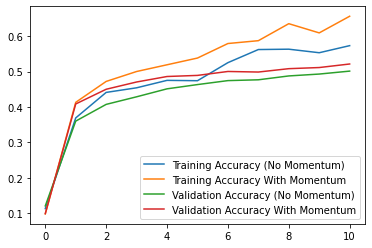

In [6]:
plt.plot(train_acc_history_SGD, label="Training Accuracy (No Momentum)")
plt.plot(train_acc_history_SGD_Momentum, label="Training Accuracy With Momentum")
plt.plot(val_acc_history_SGD, label="Validation Accuracy (No Momentum)")
plt.plot(val_acc_history_SGD_Momentum, label="Validation Accuracy With Momentum")
plt.legend()

It looks like the model with momentum trains quicker, and the ultimate validation accuracy is higher on the model with momentum as well.